https://www.kaggle.com/datasets/raghavrpotdar/fresh-and-stale-images-of-fruits-and-vegetables

In [4]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install -q kaggle

In [6]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (11).json


{'kaggle (11).json': b'{"username":"shafffaira","key":"90feefd42fcbabdb5b156bc1b71b24a6"}'}

In [7]:

# API my kaggle
#! mkdir ~/.kaggle
! cp '/content/drive/MyDrive/Colab Notebooks/Kaggle API/kaggle.json' ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! ls ~/.kaggle

kaggle.json


In [8]:
!kaggle datasets download -d raghavrpotdar/fresh-and-stale-images-of-fruits-and-vegetables

fresh-and-stale-images-of-fruits-and-vegetables.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!unzip fresh-and-stale-images-of-fruits-and-vegetables.zip -d /content/data_P3/

In [10]:
import os
os.listdir('/content/data_P3')

['stale_apple',
 'fresh_orange',
 'stale_tomato',
 'stale_orange',
 'stale_bitter_gourd',
 'fresh_apple',
 'fresh_bitter_gourd',
 'stale_capsicum',
 'fresh_tomato',
 'stale_banana',
 'fresh_banana',
 'ImageLabels.txt',
 'fresh_capsicum']

In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [12]:
!pip install -U -q evaluate transformers datasets>=2.14.5 mlflow 2>/dev/null

In [13]:
import warnings  # Import the 'warnings' module for handling warnings
warnings.filterwarnings("ignore")  # Ignore warnings during execution

import gc  # Import the 'gc' module for garbage collection
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation
import itertools  # Import 'itertools' for iterators and looping
from collections import Counter  # Import 'Counter' for counting elements
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)
from imblearn.over_sampling import RandomOverSampler # import RandomOverSampler
import evaluate  # Import the 'evaluate' module
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,  # For training arguments
    Trainer,  # For model training
    ViTImageProcessor,  # For processing image data with ViT models
    ViTForImageClassification,  # ViT model for image classification
    DefaultDataCollator  # For collating data in the default way
)
import torch  # Import PyTorch for deep learning
from torch.utils.data import DataLoader  # For creating data loaders
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)

In [14]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [15]:
image_dict = {}

# Define the list of file names
from pathlib import Path
from tqdm import tqdm
import os
# Initialize empty lists to store file names and labels
file_names = []
labels = []

# Iterate through all image files in the specified directory
for file in sorted((Path('/content/data_P3').glob('*/*.*'))):
    label = str(file).split('/')[-2]  # Extract the label from the file path
    labels.append(label)  # Add the label to the list
    file_names.append(str(file))  # Add the file path to the list

# Print the total number of file names and labels
print(len(file_names), len(labels))

# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape)

14682 14682
(14682, 2)


In [16]:
import numpy as np  # For numerical operations and array manipulation
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For plotting graphs and visualizations
import seaborn as sns  # For statistical data visualization

import cv2  # For image processing and computer vision tasks
import random  # For generating random numbers
import os  # For interacting with the operating system

import keras  # High-level neural networks API
import tensorflow as tf  # Machine learning and deep learning framework
from tqdm import tqdm  # For displaying progress bars
from sklearn.model_selection import train_test_split  # For splitting dataset into training and testing sets
from sklearn.preprocessing import LabelEncoder  # For encoding labels into numerical format
from keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Callbacks for optimizing training process
from tensorflow.keras.applications import *  # Importing pre-trained models for transfer learning
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img  # For image data augmentation and loading images
from tensorflow.keras.models import Sequential  # For creating sequential model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, BatchNormalization  # Different types of neural network layers
from tensorflow.keras.optimizers import Adam  # Optimizer for training
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # For evaluating model performance

In [17]:
df.head()

,image,label
0,/content/data_P3/fresh_apple/Screen Shot 2018-...,fresh_apple
1,/content/data_P3/fresh_apple/Screen Shot 2018-...,fresh_apple
2,/content/data_P3/fresh_apple/Screen Shot 2018-...,fresh_apple
3,/content/data_P3/fresh_apple/Screen Shot 2018-...,fresh_apple
4,/content/data_P3/fresh_apple/Screen Shot 2018-...,fresh_apple


In [18]:
df['label'].unique()

array(['fresh_apple', 'fresh_banana', 'fresh_bitter_gourd',
       'fresh_capsicum', 'fresh_orange', 'fresh_tomato', 'stale_apple',
       'stale_banana', 'stale_bitter_gourd', 'stale_capsicum',
       'stale_orange', 'stale_tomato'], dtype=object)

In [19]:
class_names = df['label'].unique().tolist()
class_names

['fresh_apple',
 'fresh_banana',
 'fresh_bitter_gourd',
 'fresh_capsicum',
 'fresh_orange',
 'fresh_tomato',
 'stale_apple',
 'stale_banana',
 'stale_bitter_gourd',
 'stale_capsicum',
 'stale_orange',
 'stale_tomato']

In [20]:
df.describe()

,image,label
count,14682,14682
unique,14682,12
top,/content/data_P3/fresh_apple/Screen Shot 2018-...,stale_apple
freq,1,2342


In [21]:
df_label=df['label'].value_counts().to_frame().reset_index()
df_label

,index,label
0,stale_apple,2342
1,fresh_apple,1693
2,stale_orange,1595
3,fresh_banana,1581
4,stale_banana,1467
5,fresh_orange,1466
6,fresh_capsicum,990
7,stale_tomato,982
8,fresh_tomato,981
9,stale_capsicum,901


## statistik deskriptif dari resolusi gambar

Image: /content/data/fresh_apple/translation_Screen Shot 2018-06-08 at 5.16.06 PM.png, Label: fresh_apple, Resolution: 226 x 210


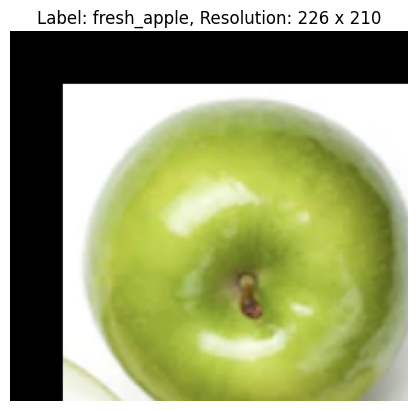

Image: /content/data/fresh_apple/vertical_flip_Screen Shot 2018-06-08 at 5.19.47 PM.png, Label: fresh_apple, Resolution: 382 x 440


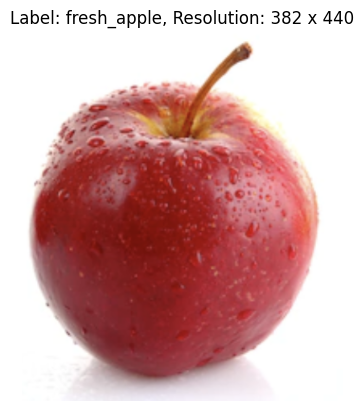

Image: /content/data/fresh_orange/saltandpepper_Screen Shot 2018-06-12 at 11.51.08 PM.png, Label: fresh_orange, Resolution: 462 x 392


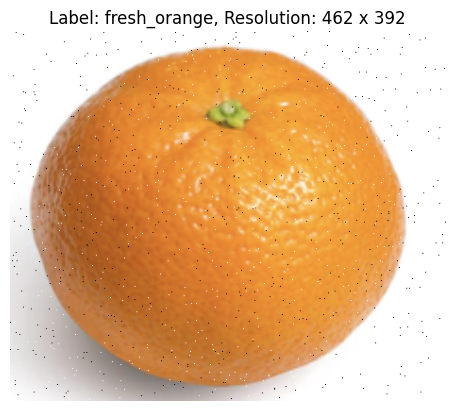

Image: /content/data/stale_apple/Screen Shot 2018-06-08 at 2.38.33 PM.png, Label: stale_apple, Resolution: 368 x 360


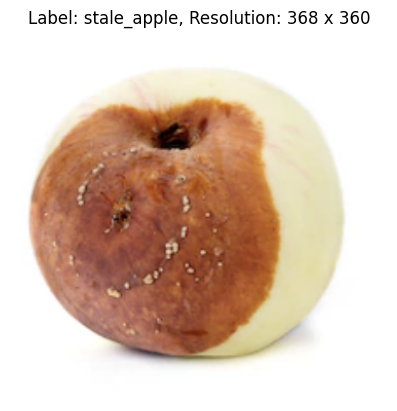

Image: /content/data/stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.20.20 PM.png, Label: stale_banana, Resolution: 678 x 396


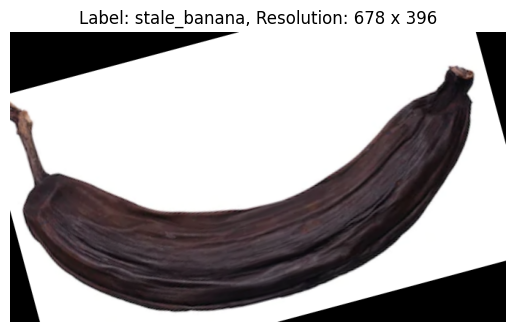


Mean Resolution: [423.2 359.6]
Standard Deviation of Resolution: [148.36495543  79.01797264]


In [22]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import random

# Menentukan direktori dataset
dataset_dir = Path('/content/data')

# Lists untuk menyimpan informasi gambar
labels = []
file_names = []
resolutions = []

# Ambil 5 sampel acak untuk ditampilkan
random_files = random.sample(list(dataset_dir.glob('*/*.*')), 5)

# Iterate through 5 random image files
for file in sorted(random_files):
    # Extract the label from the file path
    label = str(file).split('/')[-2]
    labels.append(label)

    # Add the file path to the list
    file_names.append(str(file))

    # Open the image and get its resolution
    img = Image.open(file)
    width, height = img.size
    resolutions.append((width, height))

    # Display resolution information and show the image
    print(f"Image: {file}, Label: {label}, Resolution: {width} x {height}")
    plt.imshow(img)
    plt.title(f"Label: {label}, Resolution: {width} x {height}")
    plt.axis('off')
    plt.show()

# Convert resolutions to a NumPy array for further analysis
resolutions_array = np.array(resolutions)

# Calculate descriptive statistics
mean_resolution = np.mean(resolutions_array, axis=0)
std_resolution = np.std(resolutions_array, axis=0)

print(f"\nMean Resolution: {mean_resolution}")
print(f"Standard Deviation of Resolution: {std_resolution}")

terlihat bahwa gambar memiliki resolusi berbeda-beda

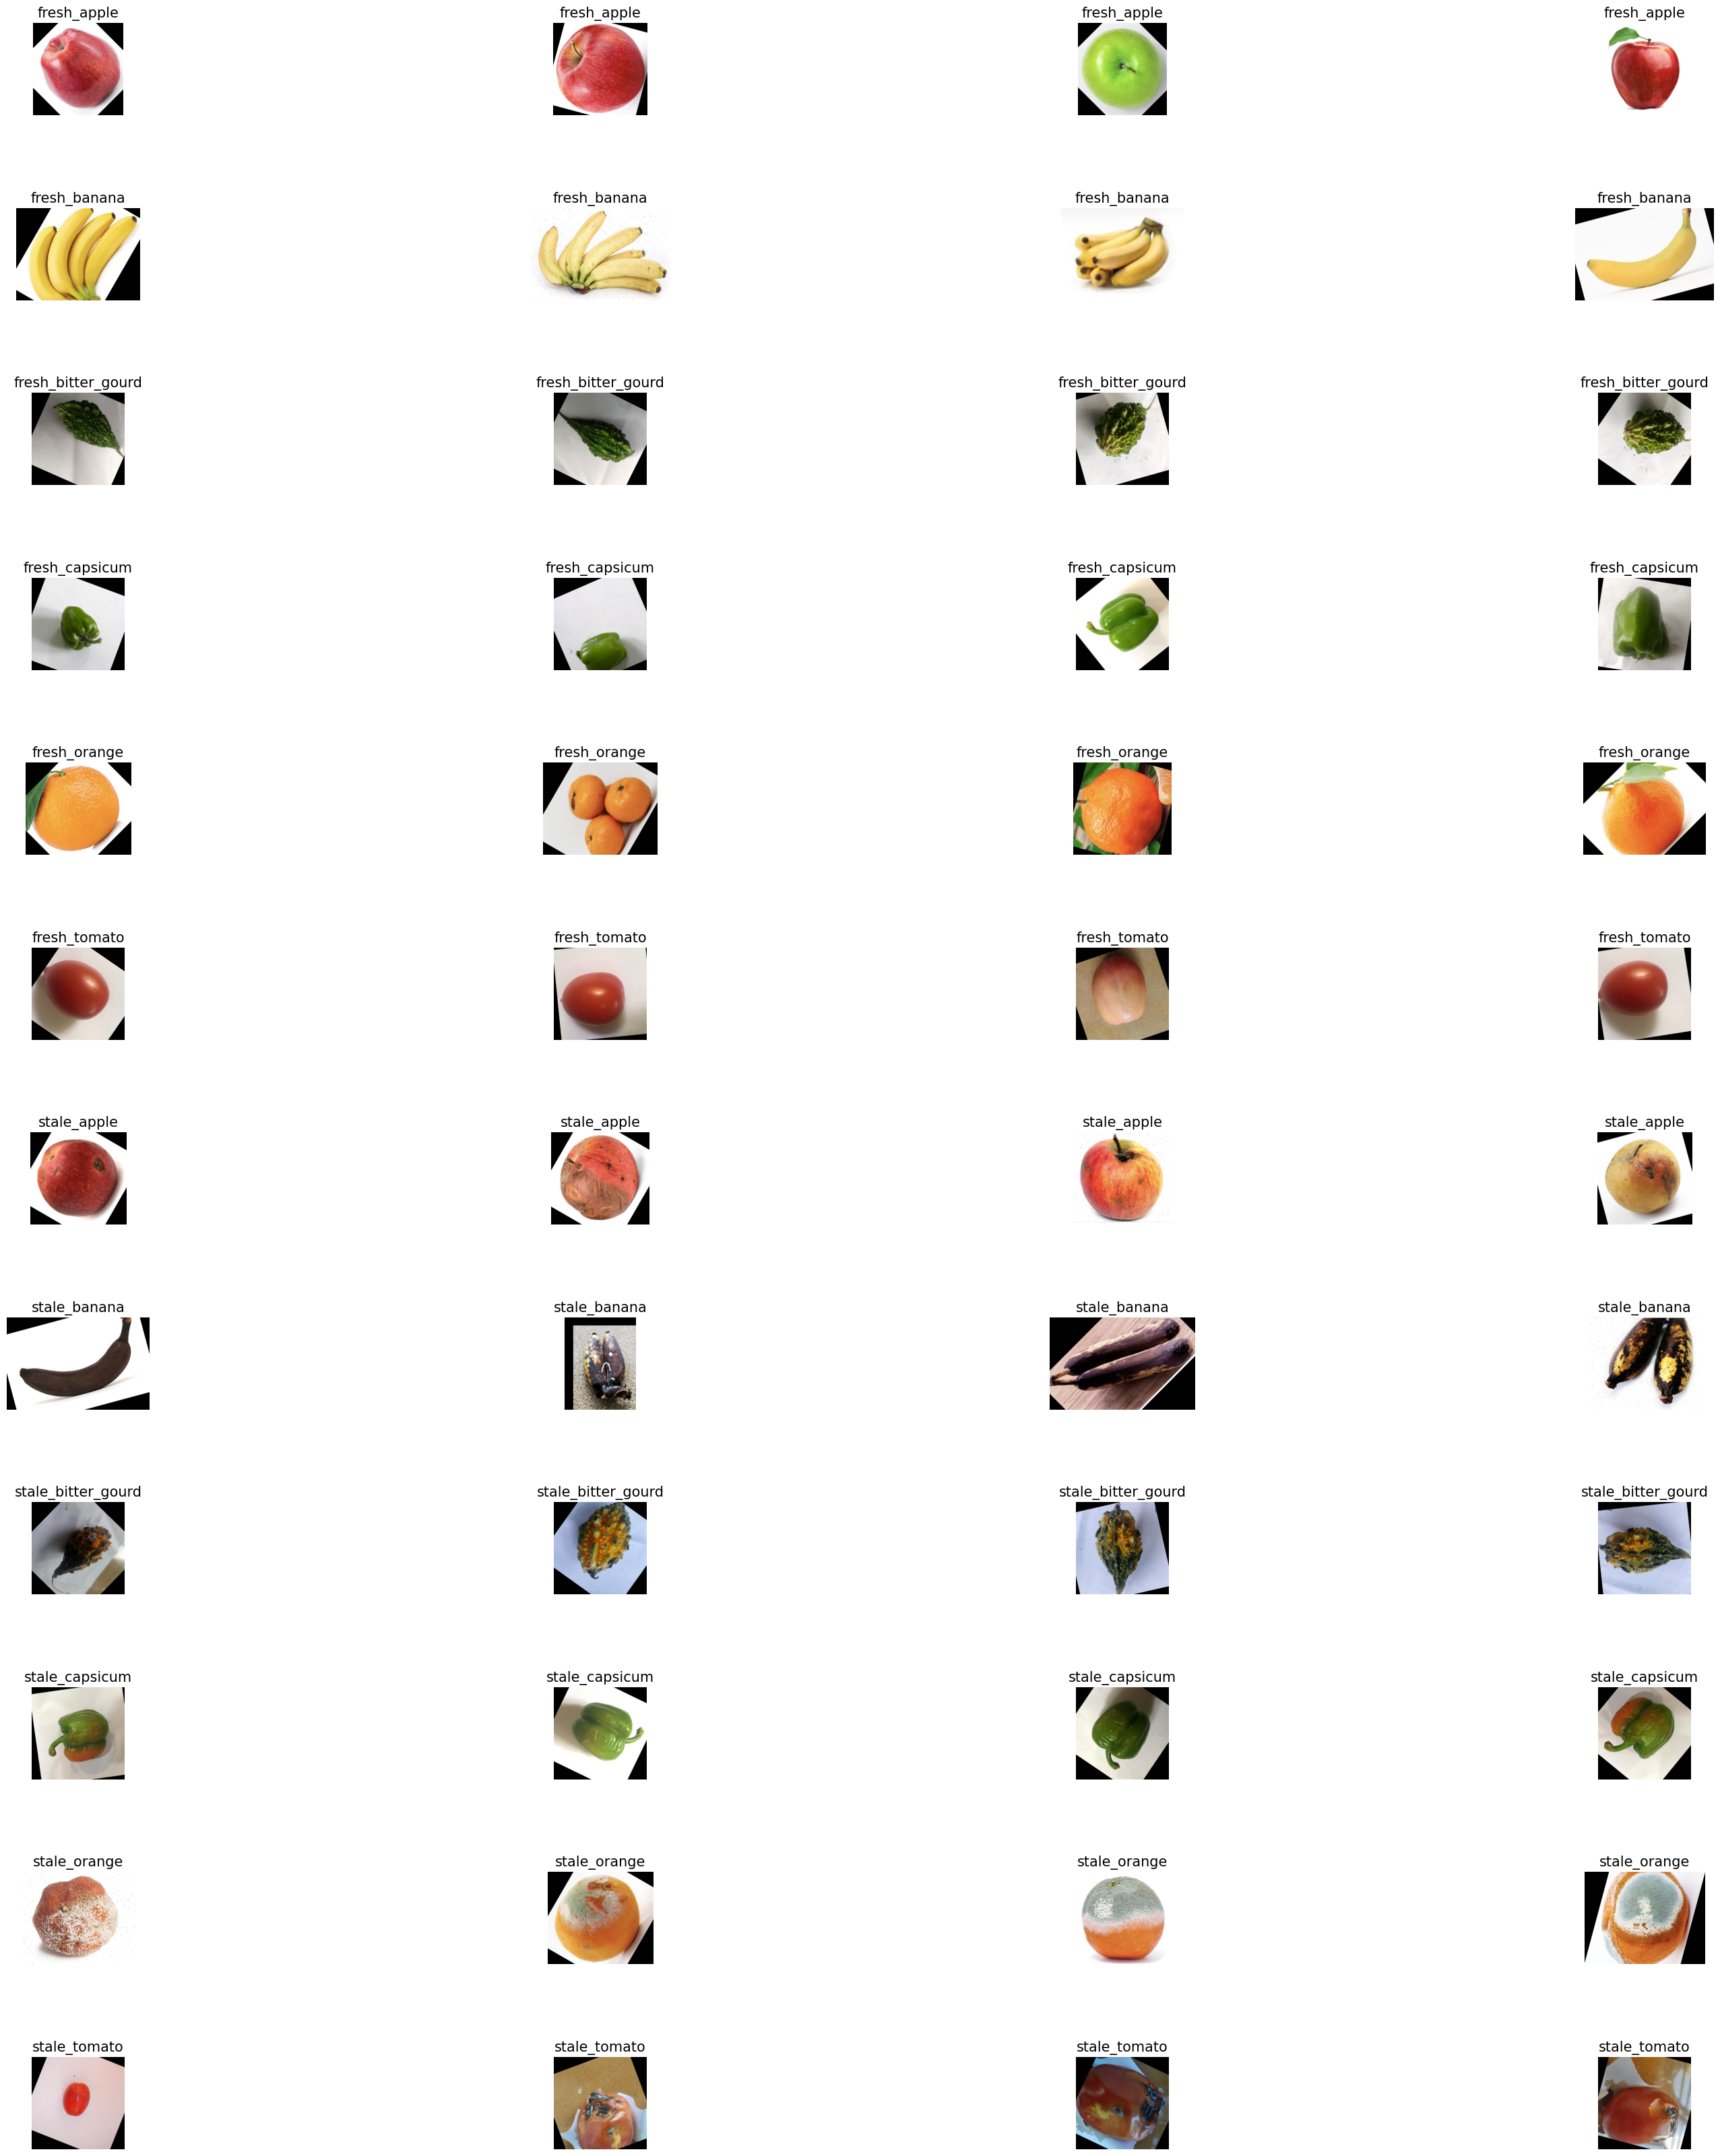

In [23]:
import cv2

grouped_data = df.groupby('label')
plt.figure(figsize=(35, 41))

# Initialize a subplot index
subplot_idx = 1

# Loop through each group (label)
for label, group in grouped_data:
    # Get 2 images from each group
    sample_images = group.sample(n=4, random_state=24)  # Change random_state for different samples

    # Loop through the sample images
    for _, row in sample_images.iterrows():
        img = cv2.imread(row['image'])  # Read the image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.subplot(len(grouped_data), 4, subplot_idx)
        plt.imshow(img)
        plt.axis('off')
        plt.title(label, fontsize=15)
        subplot_idx += 1

# Atur jarak antar gambar
plt.subplots_adjust(wspace=1, hspace=1)

plt.show()

In [24]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(df, test_size=0.2,random_state=42)

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_data_generator = ImageDataGenerator(rescale = 1./255,
                                          rotation_range=40,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode='nearest')

In [26]:
train = image_data_generator.flow_from_dataframe(dataframe=x_train,
                                                 x_col='image',
                                                 y_col='label',
                                                 target_size=(64,64),
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test,
                                                x_col='image',
                                                y_col='label',
                                                target_size=(64,64),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                shuffle=False)

Found 11745 validated image filenames belonging to 12 classes.
Found 2937 validated image filenames belonging to 12 classes.


## Conv2D Maxpooling Layer

In [27]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import Callback

In [28]:
import tensorflow as tf


model_Conv2D = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (64, 64, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(12, activation = 'softmax')
])

In [29]:
model_Conv2D.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 64)          0

In [30]:
model_Conv2D.compile(optimizer="adam",
                     loss='categorical_crossentropy',
                     metrics=["accuracy"])

In [31]:
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

#Callback Function
class accCallback(Callback):
   def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') >= 0.92 and logs.get('val_accuracy') >= 0.92):
            print("\nAccuracy and Val_Accuracy has reached 98%!", "\nEpoch: ", epoch)
            self.model.stop_training = True

callbacks = accCallback()

auto_reduction_LR = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 2, #setelah 2 epoch, jika tidak ada kenaikan maka LR berkurang
    verbose = 1,
    factor = 0.2,
    min_lr = 0.0001
)

auto_stop_learn = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0,
    patience = 4,
    verbose = 1,
    mode = 'auto'
)

In [32]:
batch_size = 2
steps_per_epoch_value = len(train) // batch_size
history = model_Conv2D.fit(train,
                           validation_data=test,
                           steps_per_epoch=steps_per_epoch_value,
                           epochs=50,
                           callbacks=[callbacks, auto_reduction_LR, auto_stop_learn]
                          )

Epoch 1/50
184/184 [==============================] - 134s 711ms/step - loss: 2.1253 - accuracy: 0.2288 - val_loss: 1.8282 - val_accuracy: 0.3095 - lr: 0.0010
Epoch 2/50
184/184 [==============================] - 107s 582ms/step - loss: 1.3234 - accuracy: 0.4975 - val_loss: 1.2308 - val_accuracy: 0.5434 - lr: 0.0010
Epoch 3/50
184/184 [==============================] - 129s 701ms/step - loss: 0.8215 - accuracy: 0.6975 - val_loss: 0.6043 - val_accuracy: 0.7869 - lr: 0.0010
Epoch 4/50
184/184 [==============================] - 126s 684ms/step - loss: 0.6401 - accuracy: 0.7668 - val_loss: 0.5671 - val_accuracy: 0.7892 - lr: 0.0010
Epoch 5/50
184/184 [==============================] - 132s 715ms/step - loss: 0.5572 - accuracy: 0.7990 - val_loss: 0.4538 - val_accuracy: 0.8359 - lr: 0.0010
Epoch 6/50
184/184 [==============================] - 126s 681ms/step - loss: 0.5078 - accuracy: 0.8209 - val_loss: 0.4387 - val_accuracy: 0.8468 - lr: 0.0010
Epoch 7/50
184/184 [==========================

In [33]:
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epoch = np.arange(1, len(accuracy_train) + 1)

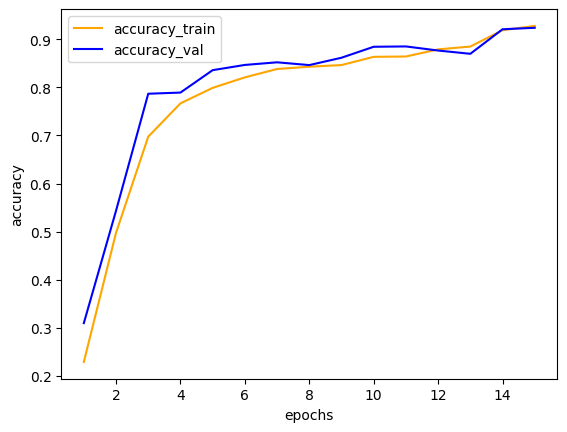

In [34]:
plt.plot(epoch, accuracy_train, 'orange')
plt.plot(epoch, accuracy_val, 'blue')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy_train', 'accuracy_val'])

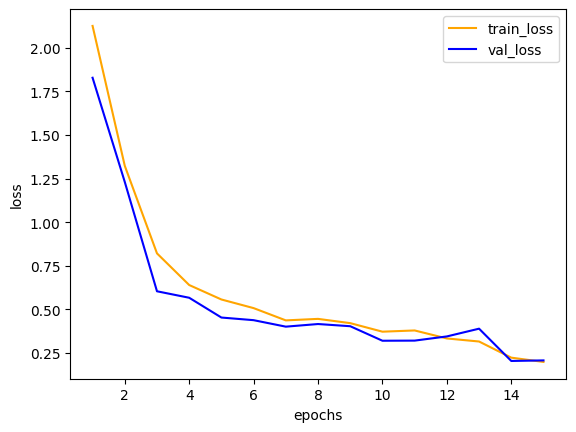

In [35]:
plt.plot(epoch, train_loss, 'orange')
plt.plot(epoch, val_loss, 'blue')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])

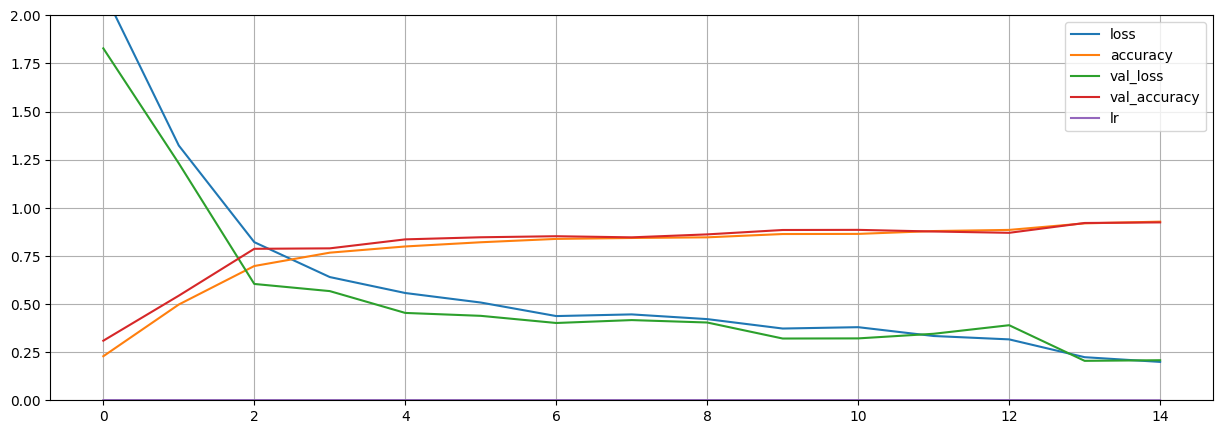

In [36]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(15, 5))
plt.grid(True)
plt.gca().set_ylim(0,2)

plt.show()

## Mengubah Model

In [38]:
# Menyimpan model dalam format SavedModel
export_dir = '/saved_model/'
tf.saved_model.save(model_Conv2D, export_dir)

# Konversi
#converter = tf.lite.TFLiteConverter.from_keras_model(export_dir)
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

import pathlib
tflite_model_file = pathlib.Path('proyek-ketiga-fruit.tflite')
tflite_model_file.write_bytes(tflite_model)

1645380